## Xử lý về dữ liệu thời gian người dùng bị sai lệch, chồng chéo, không chính xác

Vncodelab là 1 trang web dạy học trực tuyến được phát triển với mục đích tạo, dạy học và quản lý bài giảng 1 cách dễ dàng. Trong mỗi buổi học, hệ thống sẽ hiển thị chi tiết số lượng học sinh đang theo dõi, slide hiện tại của học viên, thời gian học viên ở từng slide khác nhau. Tuy nhiên do một vài sự cố kỹ thuật, khoảng thời gian học viên theo dõi từng slide đang ghi nhận kết quả không mang tính khả quan, cần được phân tích và sàng lọc kĩ càng.

Dưới đây là phương hướng của tôi về cách để can thiệp sâu và làm sạch dữ liệu mà không mất đi tính tổng quát

### Dữ liệu về log người dùng của hệ thống có tình trạng ghi nhận thông tin về thời gian người dùng chưa được chính xác. Điều này được gây nên bởi nhiều tác nhân khác nhau
1 - Do người dùng mở slide ở một trang mới, dẫn đến tình trạng trạng thái của slide cũ vẫn chưa được đóng. \
2 - Do người dùng treo máy trong một thời gian dài nên data ghi lại không được chính xác. \
3 - Do Firebase giới hạn lượt truy cập và ghi nhận của Database (dữ liệu không được lưu ở Realtime-database do dung lượng lớn).

In [1]:
{
    "Yorao":{ # Class id
        "G3ERC3":{ # Room id (tiết học)
            "document":"somethingcool", 
            "users":[
                    {
                        "user_id":"123455abcde", # ID người dùng
                        "log":[ # Log truy cập
                                {   # Hành động đầu tiên
                                "enter":14,  #Slide vào
                                "leave":13, # Slide học viên rời đi
                                "duration":58, # Khoảng thời gian ở lại slide (14)
                                "time": "14/03/2023, 11:59:35" # Mốc Thời gian học viên click vào slide (14)
                            }
                        ]
                    }
            ]
        }
    }
}

{'Yorao': {'G3ERC3': {'document': 'somethingcool',
   'users': [{'user_id': '123455abcde',
     'log': [{'enter': 14,
       'leave': 13,
       'duration': 58,
       'time': '14/03/2023, 11:59:35'}]}]}}}

Nhận ra khi sử dụng hệ thống, trang web vẫn hiển thị vị trí của học viên theo thời gian thực, điều đó chứng tỏ về thời gian đầu vào (time) của học viên có tỉ lệ đúng cao và lỗi chủ yếu xảy ra ở khoảng thời gian học viên học tập trên slide (duration)

### Chi tiết lỗi

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
f= open('data/new_raw_data.json')
data1 = f.read()
classes = json.loads(data1)
f.close()
rooms_id = set()
Yorao= classes['Yorao']
for room in Yorao:
    rooms_id.add(room)

In [4]:
def to_datetime(s:str) -> datetime:
    datetime_str = s
    datetime_object = datetime.strptime(datetime_str, '%d/%m/%Y, %H:%M:%S')
    return datetime_object
def to_second(a) -> int:
    return 3600*a.hour+60*a.minute+a.second

Lấy các log của giáo viên với email là phamxuanlam@gmail.com

In [5]:
teacher_step_dictionary= {}
teacher_email= "phamxuanlam@gmail.com"
for room in rooms_id:
    teacher_step_dictionary[room]= {}
    for i in range(len(Yorao[room]["users"])):
        if Yorao[room]["users"][i]['email'] == teacher_email:
                teacher_step_dictionary[room]['date']= to_datetime(Yorao[room]["users"][i]['logs'][0]['time']).date()
                teacher_step_dictionary[room]['steps'] =[]
                for k in range(len(Yorao[room]["users"][i]["logs"])):
                    teacher_step_dictionary[room]['steps'].append([to_second(to_datetime(Yorao[room]["users"][i]["logs"][k]['time'])), to_second(to_datetime(Yorao[room]["users"][i]["logs"][k]['time']))+ Yorao[room]["users"][i]["logs"][k]['duration'],Yorao[room]["users"][i]["logs"][k]['enter']])
    for room in teacher_step_dictionary:
         teacher_step_dictionary[room]['steps'].sort()

Biểu diễn các khoảng thời gian của giáo viên lên đồ thị với mỗi đoạn thẳng ứng với các khoảng thời gian giáo viên ở một slide nào đó

In [6]:
minn=99999999
maxx=0
for time in teacher_step_dictionary['8JSMUQ']['steps']:
    minn=min(minn,time[0],time[1])
    maxx=max(minn,time[0],time[1])
timestamp=np.array(teacher_step_dictionary['8JSMUQ']['steps'],dtype=np.int32)
a=np.ones((timestamp.shape[0],2),dtype=np.int32)*minn
b=np.concatenate([a,np.zeros((timestamp.shape[0],1),dtype=np.int32)],axis=1)
x=timestamp-b
minn

35322

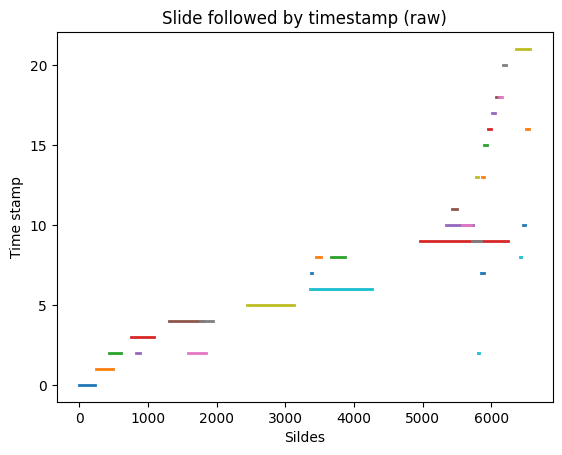

In [7]:
plt.plot([x[:,0],x[:,1]],[x[:,2],x[:,2]],linewidth=2)
plt.xlabel('Sildes') 
plt.ylabel('Time stamp')
plt.title("Slide followed by timestamp (raw)")
plt.show()

Có thể thấy là dữ liệu về thời gian người dùng có những mức bị trùng về thời gian, khiến cho nhiều lúc lầm tưởng người dùng đang ở 2 slide khác nhau, điều này gây khó khăn rất lớn trong việc theo dõi các hành động của các người dùng với nhau.

Sau khi loại bỏ những slide có duration ngắn hơn 90 giây (gap=90) ta có đồ thị mới nhìn có vẻ đẹp hơn nhưng hiện tượng trùng lặp vẫn xảy ra

In [8]:
gap=90
rmv=[]
for i,line in enumerate(x):
    if (line[1]-line[0]<gap):
        rmv.append(i)
rmv
x1=np.delete(x,rmv,axis=0)
x1[:,:]

array([[   0,  220,    0],
       [ 247,  493,    1],
       [ 427,  608,    2],
       [ 757, 1087,    3],
       [1311, 1794,    4],
       [1575, 1837,    2],
       [1759, 1943,    4],
       [2446, 3132,    5],
       [3352, 4259,    6],
       [3659, 3870,    8],
       [4954, 6249,    9],
       [5346, 5738,   10],
       [5569, 5706,   10],
       [5713, 5842,    9],
       [6366, 6568,   21]])

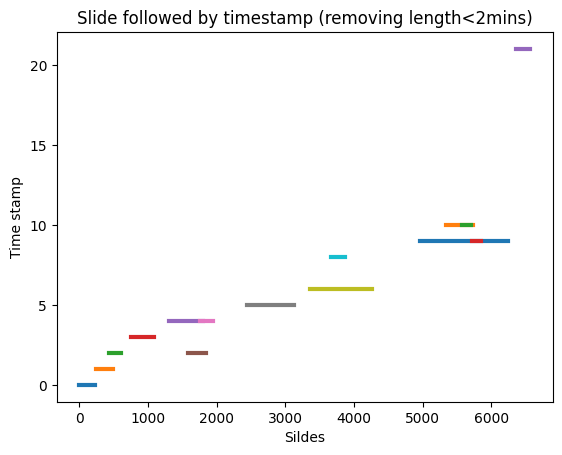

In [9]:
plt.plot([x1[:,0],x1[:,1]],[x1[:,2],x1[:,2]],linewidth=3)
plt.xlabel('Sildes') 
plt.ylabel('Time stamp')
plt.title("Slide followed by timestamp (removing length<2mins)")
plt.show()

### Giải pháp
Giải pháp được đưa ra là chỉ dữ lại các mốc thời gian đầu vào và lựa chọn khoảng thời gian (duration) sao cho kết thúc ở slide A sẽ là bắt đầu ở slide B

In [10]:
#merge consecutive logs that in the same slide
rmv2=[]
for i in range (len(x1)-1):
    if x1[i,2]==x1[i+1,2]:

        x1[i+1,0]=min(x1[i,0],x1[i+1,0])
        x1[i+1,1]=max(x1[i,1],x1[i+1,1])
        rmv2.append(i)
        continue

x2=np.delete(x1,rmv2,axis=0)
for i in range (len(x2)-1):
    if x2[i,1]<x2[i+1,0]:
        x2[i,1]=x2[i+1,0]
    elif x2[i,1]>x2[i+1,0]:
        x2[i,1]=x2[i+1,0]

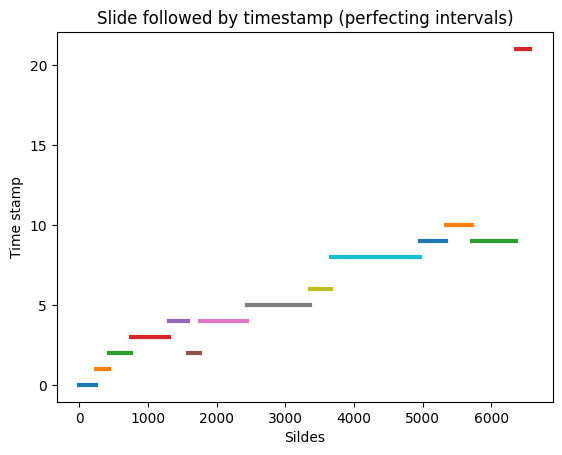

array([[   0,  247,    0],
       [ 247,  427,    1],
       [ 427,  757,    2],
       [ 757, 1311,    3],
       [1311, 1575,    4],
       [1575, 1759,    2],
       [1759, 2446,    4],
       [2446, 3352,    5],
       [3352, 3659,    6],
       [3659, 4954,    8],
       [4954, 5346,    9],
       [5346, 5713,   10],
       [5713, 6366,    9],
       [6366, 6568,   21]])

In [11]:
plt.plot([x2[:,0],x2[:,1]],[x2[:,2],x2[:,2]],linewidth=3)
plt.xlabel('Sildes') 
plt.ylabel('Time stamp')
plt.title("Slide followed by timestamp (perfecting intervals)")
plt.show()
x2

In [12]:
x3=np.delete(x1,rmv2,axis=0)
x4=np.delete(x1,rmv2,axis=0)
for i in range (len(x3)):
    x3[i,0]=max(x3[i,0],x2[i,0])
    x3[i,1]=min(x3[i,1],x2[i,1])
rate_origin=np.mean((x3[:,1]-x3[:,0])/(x4[:,1]-x4[:,0]+1e-7))


print("% preserved time cover the original time:",rate_origin)

# origin time    ________________________
# modified time  ________________________________  
#                |    preserved time    | changed

# origin time    ________________________________
# modified time  _______________________  
#                |    preserved time    | changed

% preserved time cover the original time: 0.8255704951906389


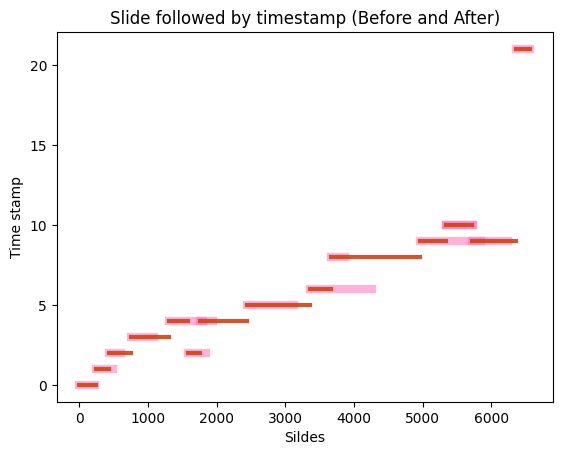

In [46]:
plt.figure()
l1=plt.plot([x1[:,0],x1[:,1]],[x1[:,2],x1[:,2]],color='hotpink',alpha=0.5,linewidth=6,label='Before')
l2=plt.plot([x2[:,0],x2[:,1]],[x2[:,2],x2[:,2]],color='#CF4213',alpha=0.9,linewidth=3,label='After')

plt.xlabel('Sildes') 
plt.ylabel('Time stamp')
plt.title("Slide followed by timestamp (Before and After)")

plt.show()

Pink: Time logs before changing \
Brown: Time logs after changing

### Đánh giá và Nhận định
Có thể thấy giải pháp này đã khiến cho bộ dữ liệu về thời gian đã được làm sạch, không xảy ra tình trạng ngắt quãng hay trùng lặp như ban đầu. \
Với tỉ lên bao phủ 83% khoảng thời gian thực tế, cách biến đổi này vẫn phần nào giữ được giá trị cốt lõi của dữ liệu, không thay đổi quá nhiều đến kết quả cuối.